In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import unicodedata
import nltk
import csv
import string
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import transformers
import warnings
import operator
import os
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import gensim

/home/slava/UNSW/translationanalysis-Georgianlanguage/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from textblob import TextBlob
from nltk.corpus import stopwords
from wordcloud import WordCloud
from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler
from torchtext import data
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import hamming_loss, jaccard_score, label_ranking_average_precision_score, f1_score
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from sklearn.metrics import jaccard_score
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
from gensim import utils
from matplotlib.ticker import StrMethodFormatter
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from scipy.special import softmax

/home/slava/UNSW/translationanalysis-Georgianlanguage/.venv/lib/python3.11/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/tmp/ipykernel_55851/1901597342.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [3]:
from roberta_new import RoBERTaCustom

In [4]:
%matplotlib inline
pd.options.display.max_colwidth = 250
SEED = 1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
warnings.filterwarnings('ignore')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/slava/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
MAX_LEN = 200 #based on length of tweets
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1
EPOCHS = 4
LEARNING_RATE = 1e-05 #tried 1e-03, 1e-04, 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base') 
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.tweet = dataframe['Tweet']
        self.targets = self.dataframe.list
        self.max_len = max_len

    def __len__(self):
        return len(self.tweet)

    def __getitem__(self, index):
        tweet = str(self.tweet[index])
        tweet = " ".join(tweet.split())
        inputs = self.tokenizer.encode_plus(
            tweet,
            None,
            add_special_tokens=True,  # Add special tokens for RoBERTa
            max_length=self.max_len,
            padding='max_length',  # Pad to max_length
            return_token_type_ids=True,
            return_tensors='pt',  # Return PyTorch tensors
            truncation=True  # Truncate sequences longer than max_length
        )
        input_ids = inputs['input_ids'].squeeze(0)  # Remove the added batch dimension
        attention_mask = inputs['attention_mask'].squeeze(0)  # Remove the added batch dimension
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [7]:
model = RoBERTaCustom(num_classes=10)
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTaCustom(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [8]:
roberta = torch.load("models/roberta-finetuned.pth")
roberta

RoBERTaCustom(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [9]:
torch.save(model.state_dict(), 'models/roberta_weights_only.pth')

In [10]:
model_new = RoBERTaCustom()
model_new.to(device)
model_new.load_state_dict(torch.load('models/roberta_weights_only.pth'))
model_new

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTaCustom(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [11]:
def test():
    roberta.eval()
    roberta_outputs = []
    with torch.no_grad():
        for unw, data in enumerate(test_loader, 0):
            input_ids = data['input_ids'].to(device, dtype=torch.long)
            attention_mask = data['attention_mask'].to(device, dtype=torch.long)
            outputs = roberta(input_ids=input_ids, attention_mask=attention_mask)
            roberta_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return roberta_outputs

In [12]:
texts_path = '../Georgian Texts/Vazha Pshavela/'
sources = ['en/', 'ggl/', 'gem/', 'gpt/']
prose_path = texts_path + 'Prose/revised/'
prose_names = []

ge_prose_directory = os.fsencode(prose_path + 'ge/')
for file in sorted(os.listdir(ge_prose_directory)):
    prose_names.append(file.decode())

In [13]:
for source in sources:
    for prose in prose_names:
        prose_text = [line.strip() for line in open(prose_path + source + prose, "r")]
        prose_df = pd.DataFrame(prose_text, columns=['Tweet'])
        prose_df['list'] = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] * len(prose_text)

        test_dataset = CustomDataset(prose_df, tokenizer, MAX_LEN)
        roberta_test_params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0}
        test_loader = DataLoader(test_dataset, **roberta_test_params)
        test_outputs = test()
        test_outputs = np.array(test_outputs)

        for i in range(test_outputs.shape[0]):
            for j in range(test_outputs.shape[1]):
                if test_outputs[i][j] >= 0.5:
                    test_outputs[i][j] = 1
                else:
                    test_outputs[i][j] = 0

        prose_df['Optimistic'] = "None"
        prose_df['Thankful'] = "None"
        prose_df['Empathetic'] = "None"
        prose_df['Pessimistic'] = "None"
        prose_df['Anxious'] = "None"
        prose_df['Sad'] = "None"
        prose_df['Annoyed'] = "None"
        prose_df['Denial'] = "None"
        prose_df['Official report'] = "None"
        prose_df['Joking'] = "None"
        prose_df = prose_df.drop(['list'], axis=1)

        for i in range(len(test_outputs)):
            prose_df['Optimistic'].iloc[i] = test_outputs[i][0]
            prose_df['Thankful'].iloc[i] = test_outputs[i][1]
            prose_df['Empathetic'].iloc[i] = test_outputs[i][2]
            prose_df['Pessimistic'].iloc[i] = test_outputs[i][3]
            prose_df['Anxious'].iloc[i] = test_outputs[i][4]
            prose_df['Sad'].iloc[i] = test_outputs[i][5]
            prose_df['Annoyed'].iloc[i] = test_outputs[i][6]
            prose_df['Denial'].iloc[i] = test_outputs[i][7]
            prose_df['Official report'].iloc[i] = test_outputs[i][8]
            prose_df['Joking'].iloc[i] = test_outputs[i][9]

        prose_df.to_csv('results/prose/sentiment/' + source + prose)

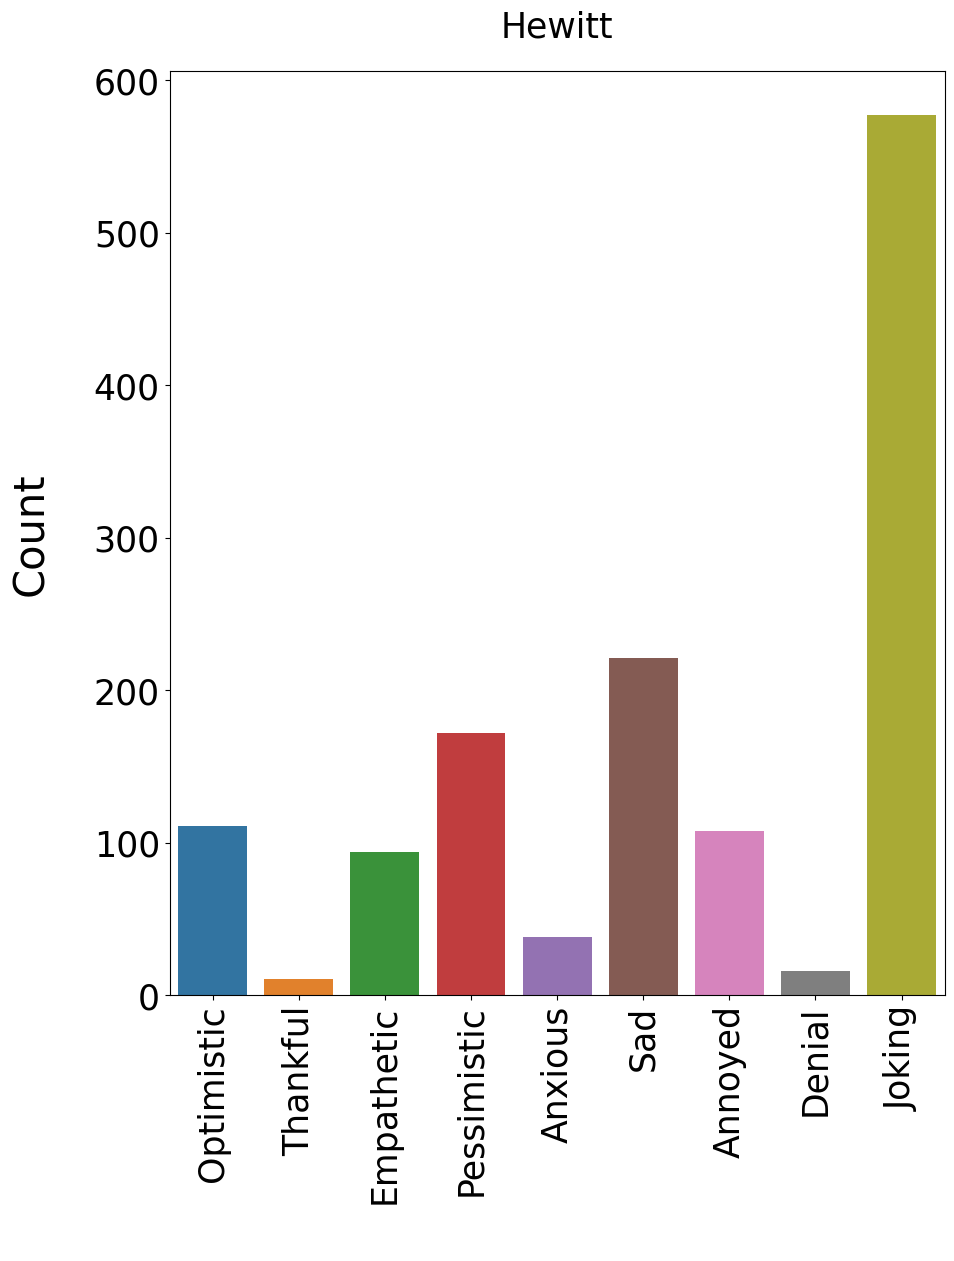

In [13]:
total_df = pd.DataFrame()
for prose in prose_names:
    df = pd.read_csv('results/prose/sentiment/' + 'en/' + prose)
    df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
    df = df.apply(pd.Series.value_counts)

    df['Optimistic'] = df['Optimistic'].fillna(0)
    df['Thankful'] = df['Thankful'].fillna(0)
    df['Empathetic'] = df['Empathetic'].fillna(0)
    df['Pessimistic'] = df['Pessimistic'].fillna(0)
    df['Anxious'] = df['Anxious'].fillna(0)
    df['Sad'] = df['Sad'].fillna(0)
    df['Annoyed'] = df['Annoyed'].fillna(0)
    df['Denial'] = df['Denial'].fillna(0)
    df['Joking'] = df['Joking'].fillna(0)    

    df = df.iloc[1]
    df = pd.DataFrame(df)
    df.columns = ['Count']
    total_df = pd.concat([total_df, df])

total_df = total_df.reset_index()
total_df = total_df.rename(columns={"index": "Sentiment"})

new_df = pd.DataFrame({
    "Sentiment":["Optimistic", "Thankful", "Empathetic", "Pessimistic", "Anxious", "Sad", "Annoyed", "Denial", "Joking"], 
    "Count":[0,0,0,0,0,0,0,0,0,]
})


for ii in range(0, 9):
    for jj in range(0, 12):
        new_df.loc[ii, 'Count'] = (new_df.loc[ii, 'Count'] + total_df.loc[jj * 9 + ii, 'Count']).astype(int)

fig_dims = (10, 12)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x=new_df.Sentiment, y=new_df.Count, ax=ax, palette=sns.color_palette("tab10"))
plt.xticks(rotation=90)
plt.ylabel('Count', labelpad=30)
plt.xlabel(' ')
plt.title('Hewitt', fontsize=25, pad=25)
ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.savefig('results/prose/graphs/sentiment/hewitt.png')

In [14]:
def all_chapter_dataframe(source):
    total_df = pd.DataFrame()
    for prose in prose_names:
        df = pd.read_csv('results/prose/sentiment/' + source + prose)
        df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
        df = df.apply(pd.Series.value_counts)

        df['Optimistic'] = df['Optimistic'].fillna(0)
        df['Thankful'] = df['Thankful'].fillna(0)
        df['Empathetic'] = df['Empathetic'].fillna(0)
        df['Pessimistic'] = df['Pessimistic'].fillna(0)
        df['Anxious'] = df['Anxious'].fillna(0)
        df['Sad'] = df['Sad'].fillna(0)
        df['Annoyed'] = df['Annoyed'].fillna(0)
        df['Denial'] = df['Denial'].fillna(0)
        df['Joking'] = df['Joking'].fillna(0)    

        df = df.iloc[1]
        df = pd.DataFrame(df)
        df.columns = ['Count']
        total_df = pd.concat([total_df, df])

    total_df = total_df.reset_index()
    total_df = total_df.rename(columns={"index": "Sentiment"})

    new_df = pd.DataFrame({
        "Sentiment":["Optimistic", "Thankful", "Empathetic", "Pessimistic", "Anxious", "Sad", "Annoyed", "Denial", "Joking"], 
        "Count":[0,0,0,0,0,0,0,0,0,]
    })

    for ii in range(0, 9):
        for jj in range(0, 12):
            new_df.loc[ii, 'Count'] = (new_df.loc[ii, 'Count'] + total_df.loc[jj * 9 + ii, 'Count']).astype(int)
    
    return new_df

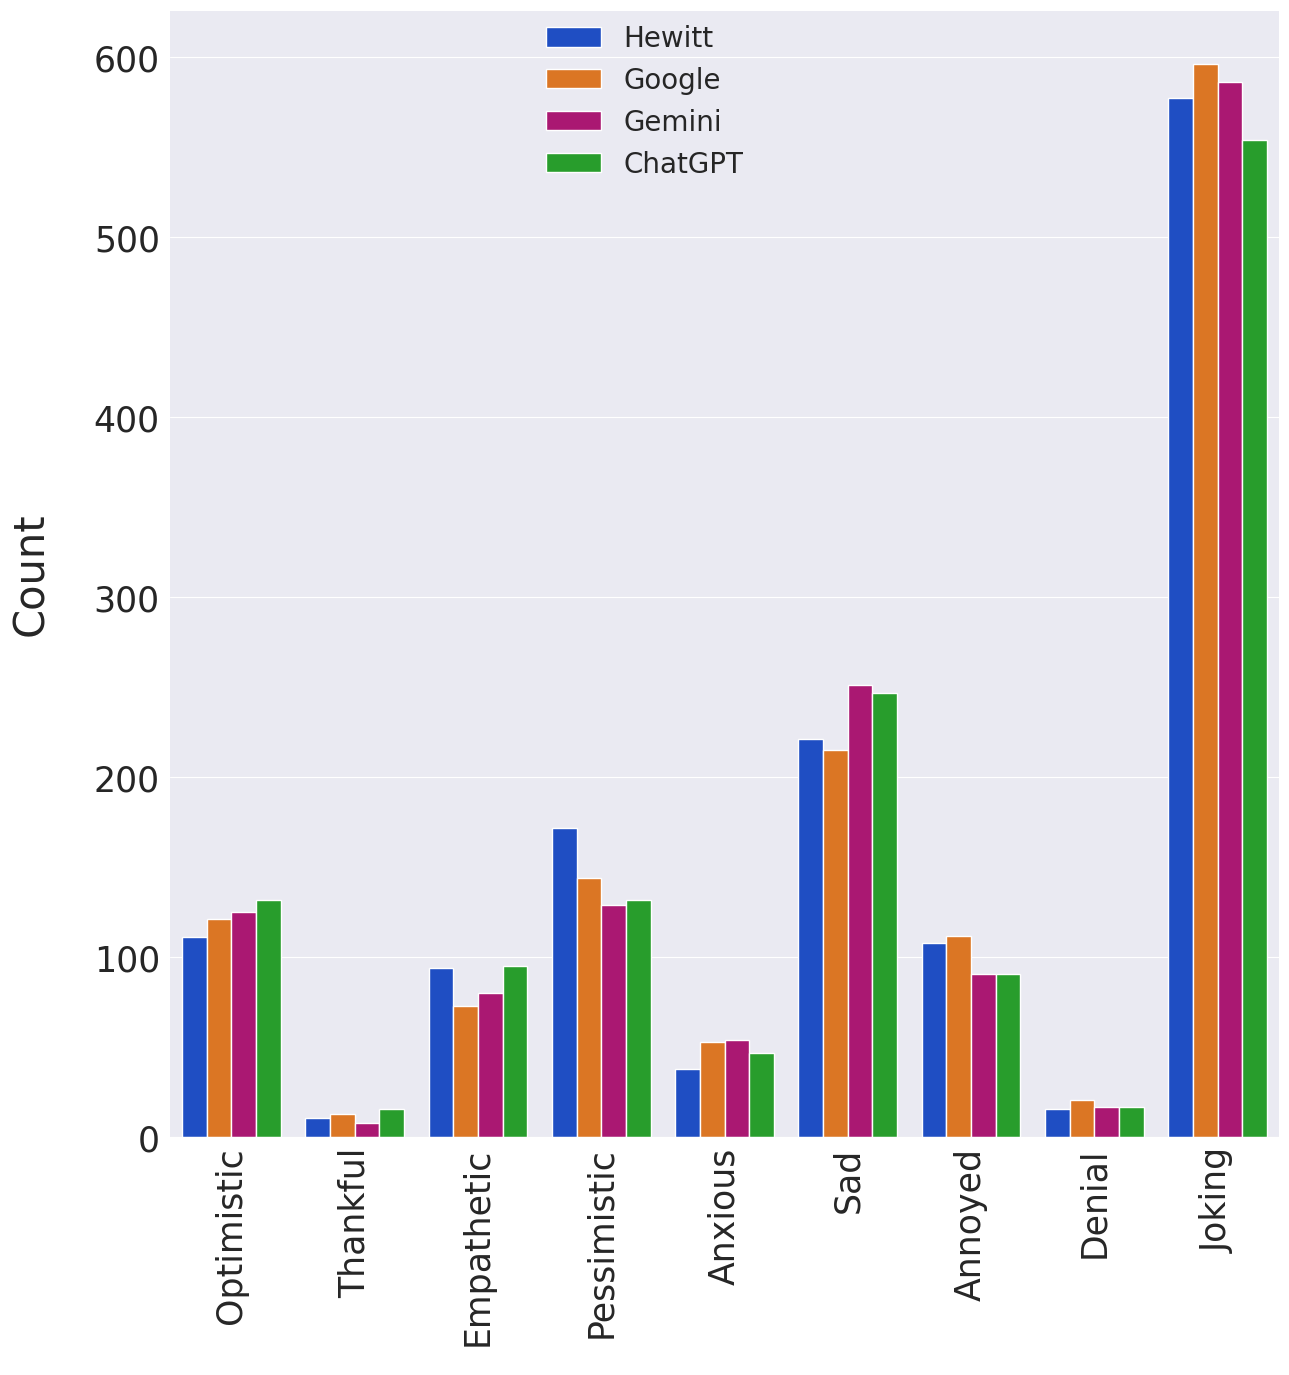

In [15]:
hewitt_sentiment = all_chapter_dataframe('en/')
google_sentiment = all_chapter_dataframe('ggl/')
gemini_sentiment = all_chapter_dataframe('gem/')
chatgpt_sentiment = all_chapter_dataframe('gpt/')

df_new = pd.concat(
    [
        hewitt_sentiment, 
        google_sentiment['Count'], 
        gemini_sentiment['Count'], 
        chatgpt_sentiment['Count']
    ],
    axis=1
)

df_new.columns = ['Sentiment', 'Hewitt', 'Google', 'Gemini', 'ChatGPT']
df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")
colors = ["blue", "orange", "magenta", "green"]  
myPalette = sns.xkcd_palette(colors)

sns.set_style("darkgrid")
g = sns.catplot(x='Sentiment', y='Count', hue='Author', data=df_new, kind='bar', height=12, palette=myPalette, legend=True)
g.despine(left=True)
sns.move_legend(g, 'upper center', prop={"size": 20}, title='')
plt.ylabel('Count', labelpad=30, fontsize=30)
plt.xlabel(' ')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.yticks(fontsize= 25)
plt.xticks(fontsize = 25)
plt.xticks(rotation=90)
plt.savefig('results/prose/graphs/sentiment/all.png')

In [16]:
def chapter_wise_dataframe(source, prose):
    df = pd.read_csv('results/prose/sentiment/' + source + prose)
    df = df.drop(['Tweet', 'Unnamed: 0', 'Official report'], axis=1)
    df = df.apply(pd.Series.value_counts)
    df['Optimistic'] = df['Optimistic'].fillna(0)
    df['Thankful'] = df['Thankful'].fillna(0)
    df['Empathetic'] = df['Empathetic'].fillna(0)
    df['Pessimistic'] = df['Pessimistic'].fillna(0)
    df['Anxious'] = df['Anxious'].fillna(0)
    df['Sad'] = df['Sad'].fillna(0)
    df['Annoyed'] = df['Annoyed'].fillna(0)
    df['Denial'] = df['Denial'].fillna(0)
    df['Joking'] = df['Joking'].fillna(0)
    df = df.iloc[1]
    df = pd.DataFrame(df)
    df.columns = ['Count']
    return df

In [17]:
sentiment_df = pd.DataFrame()
for prose in prose_names:
    hewitt_df = chapter_wise_dataframe('en/', prose)
    google_df = chapter_wise_dataframe('ggl/', prose)
    gemini_df = chapter_wise_dataframe('gem/', prose)
    chatgpt_df =chapter_wise_dataframe('gpt/', prose)
    df_new = pd.concat(
        [
            hewitt_df, 
            google_df['Count'], 
            gemini_df['Count'], 
            chatgpt_df['Count']
        ], 
        axis=1
    )
    df_new['Prose'] = prose[3:-3].replace('_', ' ').title()
    df_new.columns = ['Hewitt', 'Google', 'Gemini', 'ChatGPT', 'Prose']
    df_new = df_new.reset_index()
    df_new = df_new.rename(columns={"index":"Sentiment"})
    df_new = pd.melt(df_new, id_vars=["Sentiment", "Prose"], var_name="Author", value_name="Count")
    sentiment_df = pd.concat([sentiment_df, df_new])

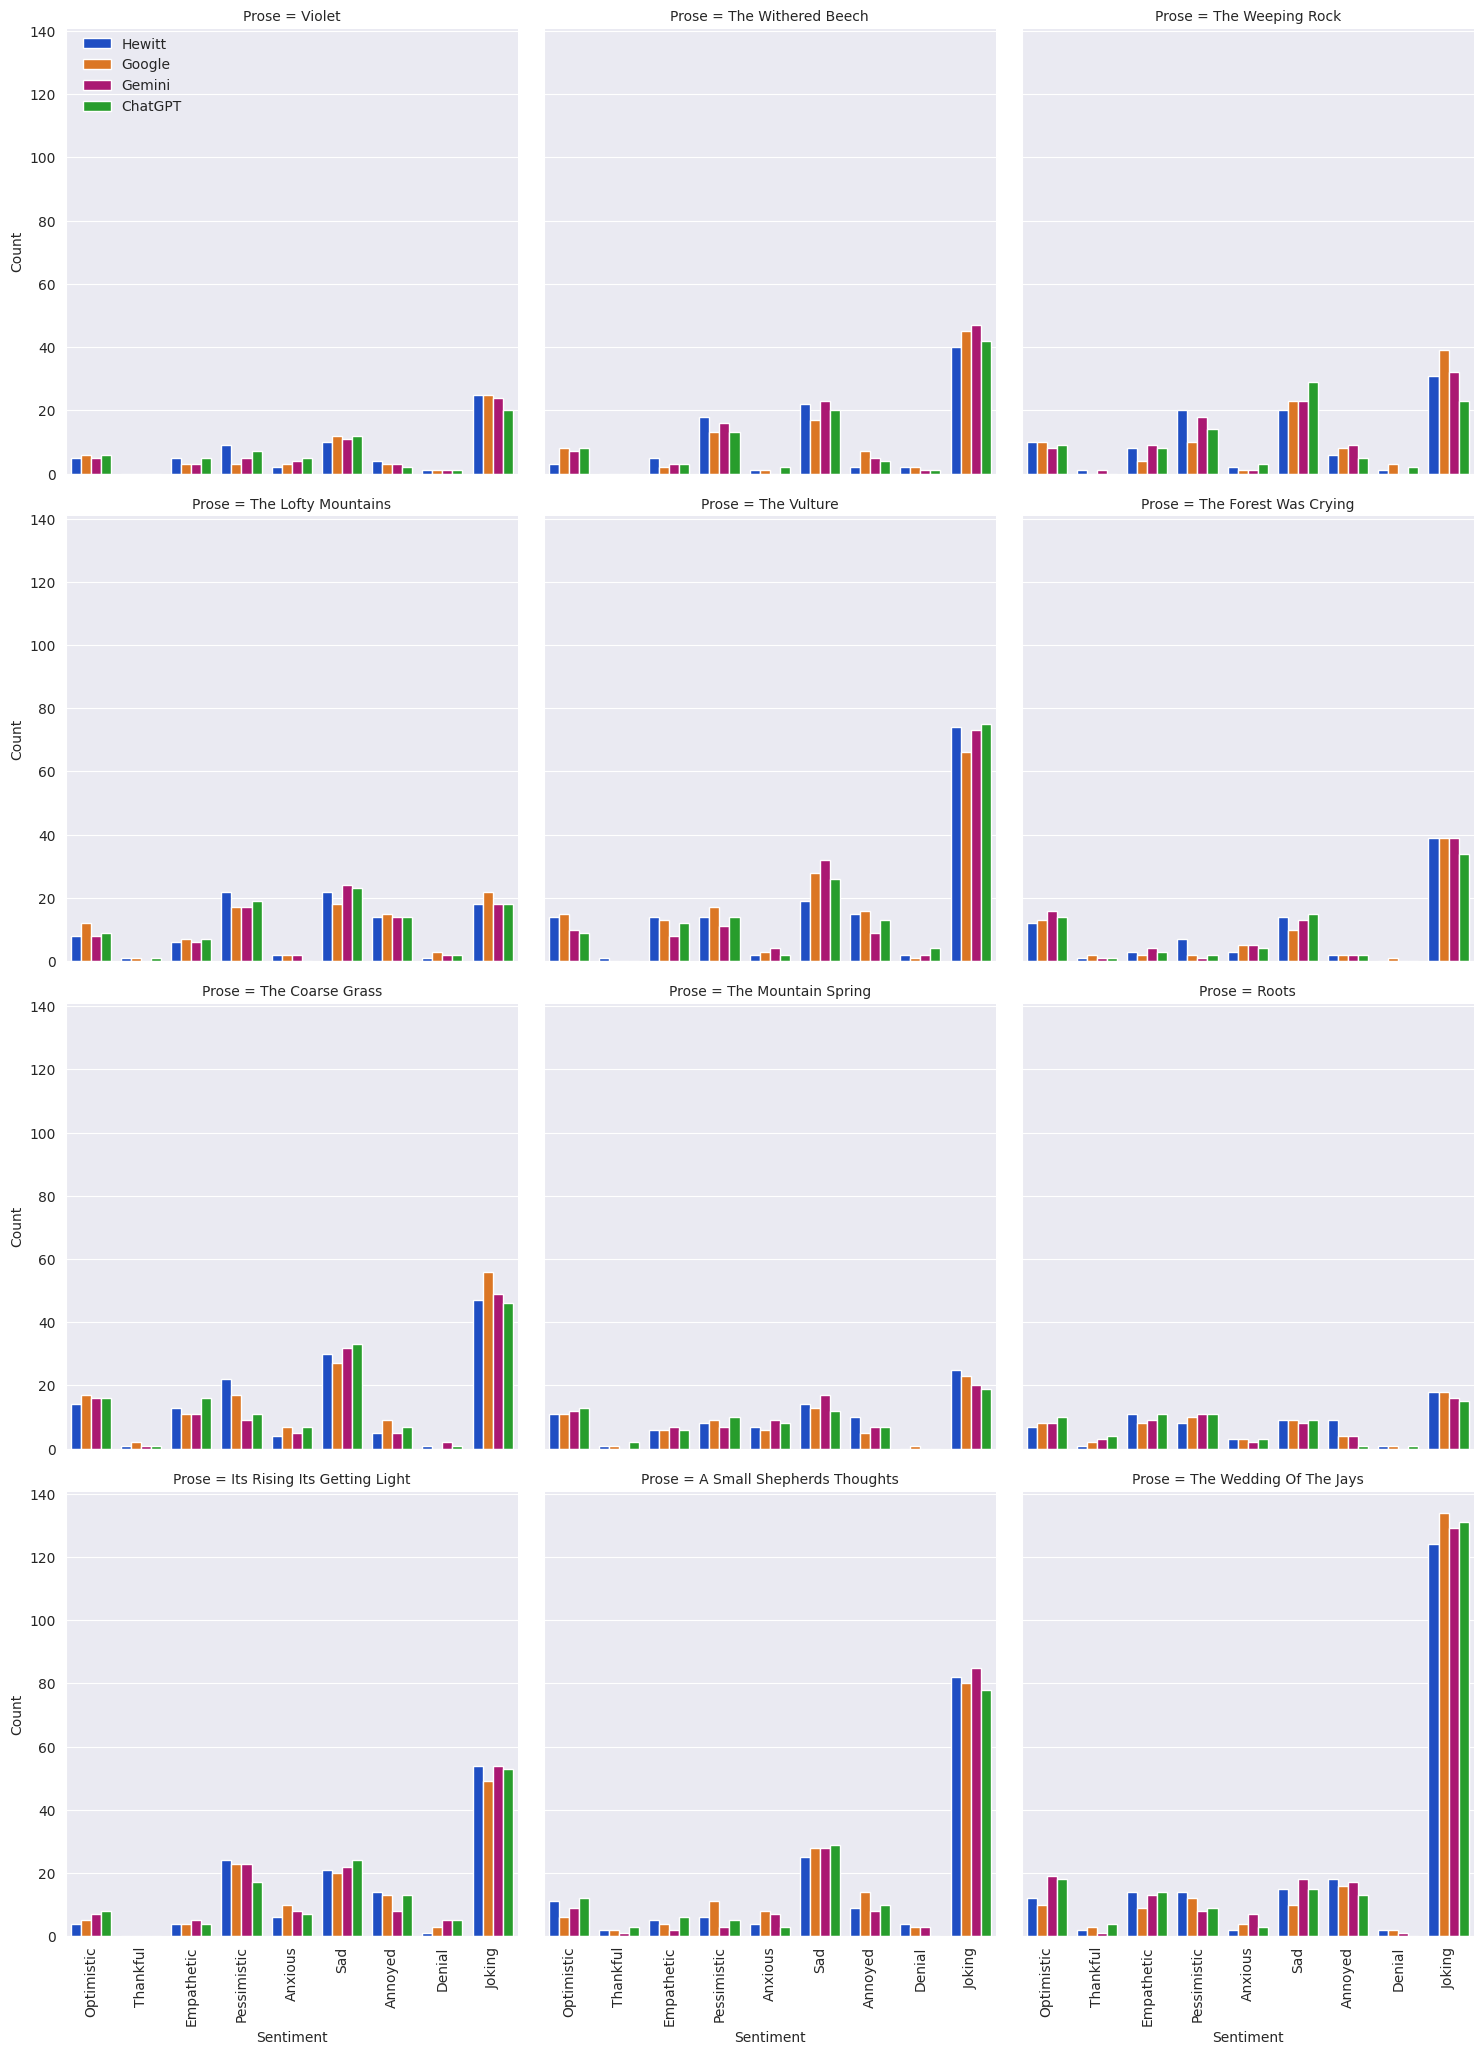

In [18]:
colors = ["blue", "orange", "magenta", "green"]  
myPalette = sns.xkcd_palette(colors)
sns.set_style("darkgrid")
g = sns.catplot(
    x='Sentiment', 
    y='Count', 
    col='Prose',
    hue='Author', 
    data=sentiment_df, 
    kind='bar', 
    palette=myPalette,
    col_wrap=3, 
    legend=True
)
g.set_xticklabels(labels=g.axes.flat[-1].get_xticklabels(), rotation=90)
#g.tick_params(axis='x', rotation=90)
sns.move_legend(g, 'upper left', bbox_to_anchor=(0.05, 0.985), title='')

In [19]:
df_new.head()

Sentiment                    Prose  Author  Count
0   Optimistic  The Wedding Of The Jays  Hewitt   12.0
1     Thankful  The Wedding Of The Jays  Hewitt    2.0
2   Empathetic  The Wedding Of The Jays  Hewitt   14.0
3  Pessimistic  The Wedding Of The Jays  Hewitt   14.0
4      Anxious  The Wedding Of The Jays  Hewitt    2.0

In [20]:
df_new.reset_index()

index    Sentiment                    Prose   Author  Count
0       0   Optimistic  The Wedding Of The Jays   Hewitt   12.0
1       1     Thankful  The Wedding Of The Jays   Hewitt    2.0
2       2   Empathetic  The Wedding Of The Jays   Hewitt   14.0
3       3  Pessimistic  The Wedding Of The Jays   Hewitt   14.0
4       4      Anxious  The Wedding Of The Jays   Hewitt    2.0
5       5          Sad  The Wedding Of The Jays   Hewitt   15.0
6       6      Annoyed  The Wedding Of The Jays   Hewitt   18.0
7       7       Denial  The Wedding Of The Jays   Hewitt    2.0
8       8       Joking  The Wedding Of The Jays   Hewitt  124.0
9       9   Optimistic  The Wedding Of The Jays   Google   10.0
10     10     Thankful  The Wedding Of The Jays   Google    3.0
11     11   Empathetic  The Wedding Of The Jays   Google    9.0
12     12  Pessimistic  The Wedding Of The Jays   Google   12.0
13     13      Anxious  The Wedding Of The Jays   Google    4.0
14     14          Sad  The Wedding Of The Jays   Google   10.0
15     15      Annoyed  The Wedding Of The Jays   Google   16.0
16     16       Denial  The Wedding Of The Jays   Google    2.0
17     17       Joking  The Wedding Of The Jays   Google  134.0
18     18   Optimistic  The Wedding Of The Jays   Gemini   19.0
19     19     Thankful  The Wedding Of The Jays   Gemini    1.0
20     20   Empathetic  The Wedding Of The Jays   Gemini   13.0
21     21  Pessimistic  The Wedding Of The Jays   Gemini    8.0
22     22      Anxious  The Wedding Of The Jays   Gemini    7.0
23     23          Sad  The Wedding Of The Jays   Gemini   18.0
24     24      Annoyed  The Wedding Of The Jays   Gemini   17.0
25     25       Denial  The Wedding Of The Jays   Gemini    1.0
26     26       Joking  The Wedding Of The Jays   Gemini  129.0
27     27   Optimistic  The Wedding Of The Jays  ChatGPT   18.0
28     28     Thankful  The Wedding Of The Jays  ChatGPT    4.0
29     29   Empathetic  The Wedding Of The Jays  ChatGPT   14.0
30     30  Pessimistic  The Wedding Of The Jays  ChatGPT    9.0
31     31      Anxious  The Wedding Of The Jays  ChatGPT    3.0
32     32          Sad  The Wedding Of The Jays  ChatGPT   15.0
33     33      Annoyed  The Wedding Of The Jays  ChatGPT   13.0
34     34       Denial  The Wedding Of The Jays  ChatGPT    0.0
35     35       Joking  The Wedding Of The Jays  ChatGPT  131.0

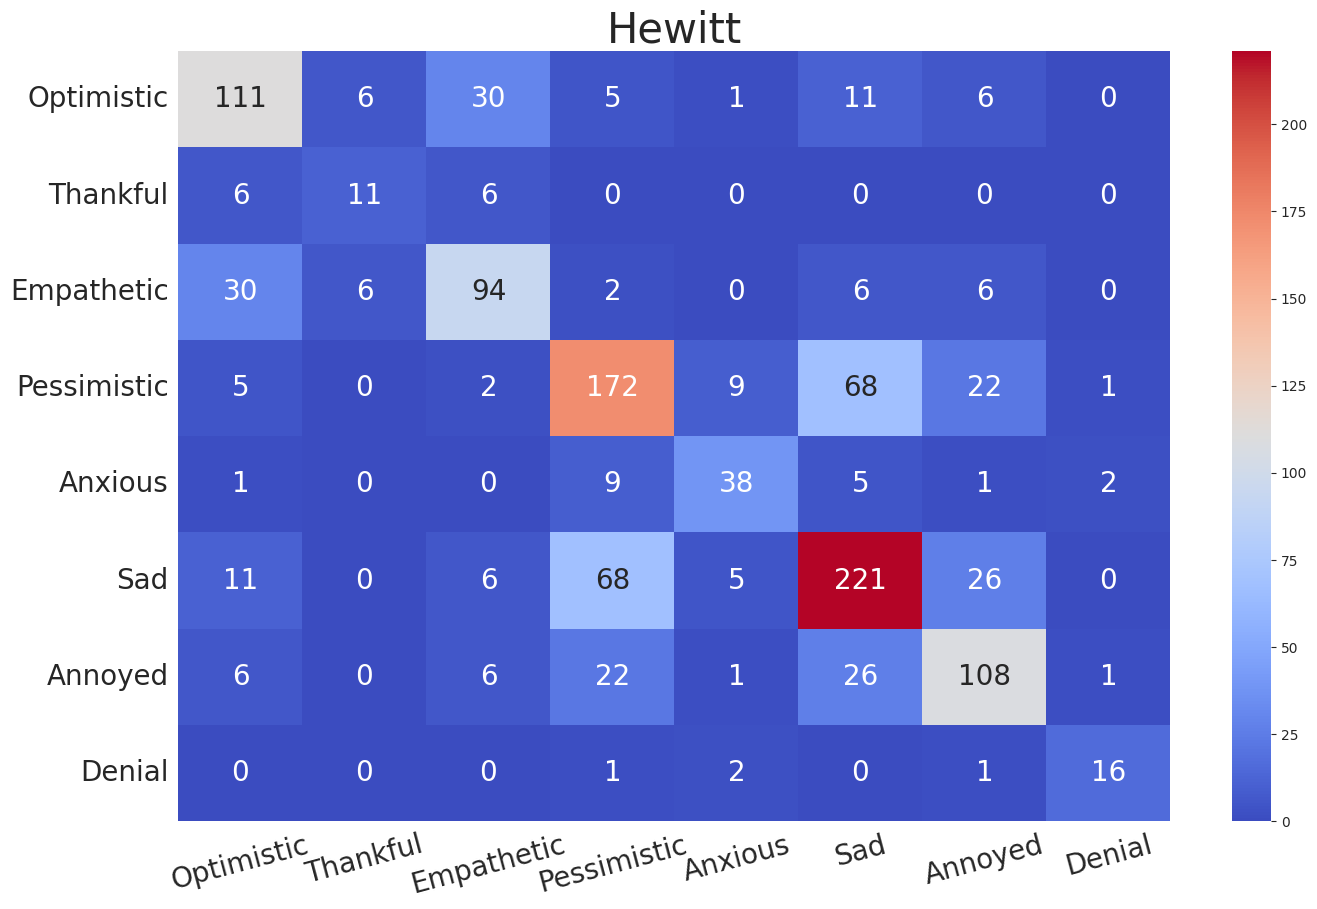

In [24]:
prose_source = 'en/'
heatmap_df = pd.read_csv('results/prose/sentiment/' + prose_source + prose_names[0])
heatmap_df = heatmap_df.drop(['Tweet', 'Unnamed: 0', 'Official report', 'Joking'], axis=1)

for prose in prose_names[1:]:
  df = pd.read_csv('results/prose/sentiment/' + prose_source + prose)
  df = df.drop(['Tweet', 'Unnamed: 0', 'Official report', 'Joking'], axis=1)
  heatmap_df = pd.concat([heatmap_df, df], axis=0)

emote_array = np.zeros((8, 8))
e2i = {'Optimistic': 0, 'Thankful': 1, 'Empathetic': 2, 'Pessimistic': 3, 'Anxious': 4, 'Sad': 5, 'Annoyed': 6, 'Denial': 7}

for i in range(len(heatmap_df)):
    l = heatmap_df.iloc[i].tolist()
    for j in range(8):
        if l[j] == 1:
            emote_array[j][j] += 1
        for k in range(j+1, 8):
            if (l[j] == 1) and (l[k] == 1):
                emote_array[j][k] += int(1)
                emote_array[k][j] += int(1)

emotions = ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial']
emote_df = pd.DataFrame(emote_array, columns=emotions)
for col in emote_df:
    emote_df[col] = emote_df[col].astype(int)

fig = plt.figure(figsize = (16, 10))
sns.heatmap(emote_df, annot=True, cmap='coolwarm', xticklabels=emote_df.columns, yticklabels=emote_df.columns, fmt='g', annot_kws={"size": 20})
plt.xticks(fontsize=20, rotation=15)
plt.yticks(fontsize=20, rotation=0)
plt.title("Hewitt", fontsize=30)
plt.savefig('results/prose/graphs/heatmaps/hewitt.png')

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Optimistic'),
  Text(1, 0, 'Thankful'),
  Text(2, 0, 'Empathetic'),
  Text(3, 0, 'Pessimistic'),
  Text(4, 0, 'Anxious'),
  Text(5, 0, 'Sad'),
  Text(6, 0, 'Annoyed'),
  Text(7, 0, 'Denial'),
  Text(8, 0, 'Joking')])

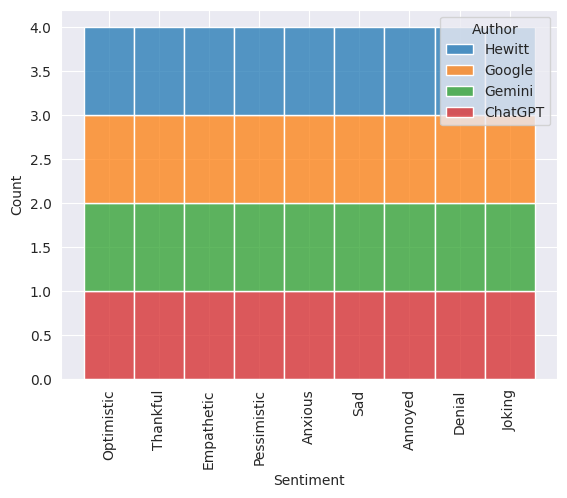

In [25]:
hewitt_sentiment = all_chapter_dataframe('en/')
google_sentiment = all_chapter_dataframe('ggl/')
gemini_sentiment = all_chapter_dataframe('gem/')
chatgpt_sentiment = all_chapter_dataframe('gpt/')

df_new = pd.concat([
        hewitt_sentiment, 
        google_sentiment['Count'], 
        gemini_sentiment['Count'], 
        chatgpt_sentiment['Count']
    ], 
    axis=1
)
df_new.columns = ['Sentiment', 'Hewitt', 'Google', 'Gemini', 'ChatGPT'] 
df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")
sns.histplot(data=df_new, x='Sentiment', hue='Author', multiple='stack')
plt.xticks(rotation=90)

In [26]:
hewitt_prose_01 = pd.read_csv('results/prose/sentiment/en/' + prose_names[0])
google_prose_01 = pd.read_csv('results/prose/sentiment/ggl/' + prose_names[0])
gemini_prose_01 = pd.read_csv('results/prose/sentiment/gem/' + prose_names[0])
chatgpt_prose_01 = pd.read_csv('results/prose/sentiment/gpt/' + prose_names[0])

hewitt_prose_01_short = hewitt_prose_01.drop(['Unnamed: 0', 'Tweet', 'Official report', 'Joking'], axis=1)
google_prose_01_short = google_prose_01.drop(['Unnamed: 0', 'Tweet', 'Official report', 'Joking'], axis=1)
gemini_prose_01_short = gemini_prose_01.drop(['Unnamed: 0', 'Tweet', 'Official report', 'Joking'], axis=1)
chatgpt_prose_01_short = chatgpt_prose_01.drop(['Unnamed: 0', 'Tweet', 'Official report', 'Joking'], axis=1)

In [27]:
y_true = np.array([[0, 1, 1],
                   [1, 1, 0]])
y_pred = np.array([[1, 1, 1],
                   [1, 0, 0]])

In [28]:
for ii in range(0, hewitt_prose_01_short.shape[0]):
    print(jaccard_score(google_prose_01_short.iloc[ii, :], hewitt_prose_01_short.iloc[ii, :]))

0.5
1.0
0.0
0.0
0.0
0.0
0.5
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.5
0.0
0.5
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.5


In [44]:
hewitt_ggl_df = pd.DataFrame()
hewitt_gem_df = pd.DataFrame()
hewitt_gpt_df = pd.DataFrame()

prose_list = []
hewitt_ggl_lst = []
hewitt_gem_lst = []
hewitt_gpt_lst = []

ggl = []
gem = []
gpt = []

sum1 = 0
sum2 = 0
sum3 = 0

for prose in prose_names:
    hewitt_df = pd.read_csv('results/prose/sentiment/' + 'en/' + prose)
    google_df = pd.read_csv('results/prose/sentiment/' + 'ggl/' + prose)
    gemini_df = pd.read_csv('results/prose/sentiment/' + 'gem/' + prose)
    chatgpt_df = pd.read_csv('results/prose/sentiment/' + 'gpt/' + prose)

    hewitt_df = hewitt_df.drop(['Unnamed: 0', 'Tweet', 'Official report', 'Joking'], axis=1)
    google_df = google_df.drop(['Unnamed: 0', 'Tweet', 'Official report', 'Joking'], axis=1)
    gemini_df = gemini_df.drop(['Unnamed: 0', 'Tweet', 'Official report', 'Joking'], axis=1)
    chatgpt_df = chatgpt_df.drop(['Unnamed: 0', 'Tweet', 'Official report', 'Joking'], axis=1)

    for ii in range(0, hewitt_df.shape[0]):
        hewitt_ggl_lst.append(f1_score(hewitt_df.iloc[ii, :], google_df.iloc[ii, :], average='micro'))
        hewitt_gem_lst.append(f1_score(hewitt_df.iloc[ii, :], gemini_df.iloc[ii, :], average='micro'))
        hewitt_gpt_lst.append(f1_score(hewitt_df.iloc[ii, :], chatgpt_df.iloc[ii, :], average='micro'))

    prose_list.append(prose)

    hewitt_ggl_df1 = pd.DataFrame(prose_list, columns=['Prose'])
    hewitt_ggl_df2 = pd.DataFrame(hewitt_ggl_lst, columns=['Hewitt - Google'])
    hewitt_ggl_df  = pd.concat([hewitt_ggl_df1, hewitt_ggl_df2], axis=1)

    hewitt_gem_df1 = pd.DataFrame(prose_list, columns=['Prose'])
    hewitt_gem_df2 = pd.DataFrame(hewitt_gem_lst, columns=['Hewitt - Gemini'])
    hewitt_gem_df  = pd.concat([hewitt_gem_df1, hewitt_gem_df2], axis=1)

    hewitt_gpt_df1 = pd.DataFrame(prose_list, columns=['Prose'])
    hewitt_gpt_df2 = pd.DataFrame(hewitt_gpt_lst, columns=['Hewitt - ChatGPT'])
    hewitt_gpt_df  = pd.concat([hewitt_gpt_df1, hewitt_gpt_df2], axis=1)    

    ggl.append(hewitt_ggl_df['Hewitt - Google'].mean())
    hewitt_ggl_df3 = pd.DataFrame(ggl, columns=['Hewitt - Google'])
    hewitt_ggl_df4 = pd.concat([hewitt_ggl_df1, hewitt_ggl_df3], axis=1)

    gem.append(hewitt_gem_df['Hewitt - Gemini'].mean())
    hewitt_gem_df3 = pd.DataFrame(gem, columns=['Hewitt - Gemini'])
    hewitt_gem_df4 = pd.concat([hewitt_gem_df1, hewitt_gem_df3], axis=1)

    gpt.append(hewitt_gpt_df['Hewitt - ChatGPT'].mean())
    hewitt_gpt_df3 = pd.DataFrame(gpt, columns=['Hewitt - ChatGPT'])
    hewitt_gpt_df4 = pd.concat([hewitt_gpt_df1, hewitt_gpt_df3], axis=1)

    # print('Prose "', str(prose[3:-3].replace('_', ' ').title()), '" Average')
    # print('Hewitt - Google ', hewitt_ggl_df['Hewitt - Google'].mean())
    # print('Hewitt - Gemini ', hewitt_gem_df['Hewitt - Gemini'].mean())
    # print('Hewitt - ChatGPT ', hewitt_gpt_df['Hewitt - ChatGPT'].mean())
    # print('\n')

    sum1 += hewitt_ggl_df['Hewitt - Google'].mean()
    sum2 += hewitt_gem_df['Hewitt - Gemini'].mean()
    sum3 += hewitt_gpt_df['Hewitt - ChatGPT'].mean()

In [45]:
sum1 = sum1 / len(prose_names)
sum2 = sum2 / len(prose_names)
sum3 = sum3 / len(prose_names)

print('Hewitt - Google', round(sum1, 4))
print('Hewitt - Gemini', round(sum2, 4))
print('Hewitt - ChatGPT', round(sum3, 4))

Hewitt - Google 0.897
Hewitt - Gemini 0.9134
Hewitt - ChatGPT 0.9065


In [46]:
hewitt_ggl_df1 = pd.DataFrame(prose_list, columns=['Prose'])
hewitt_ggl_df2 = pd.DataFrame(hewitt_ggl_df4, columns=['Hewitt - Google'])
hewitt_ggl_df = pd.concat([hewitt_ggl_df1, hewitt_ggl_df2], axis=1)
df_final = pd.concat([
        hewitt_ggl_df, 
        hewitt_gem_df3['Hewitt - Gemini'], 
        hewitt_gpt_df3['Hewitt - ChatGPT']
    ], 
    axis=1
)
# df_final

In [47]:
data = pd.melt(df_final, ['Prose'])
data['Prose'] = data['Prose'].str.replace('_', ' ').str.title().str[:3]

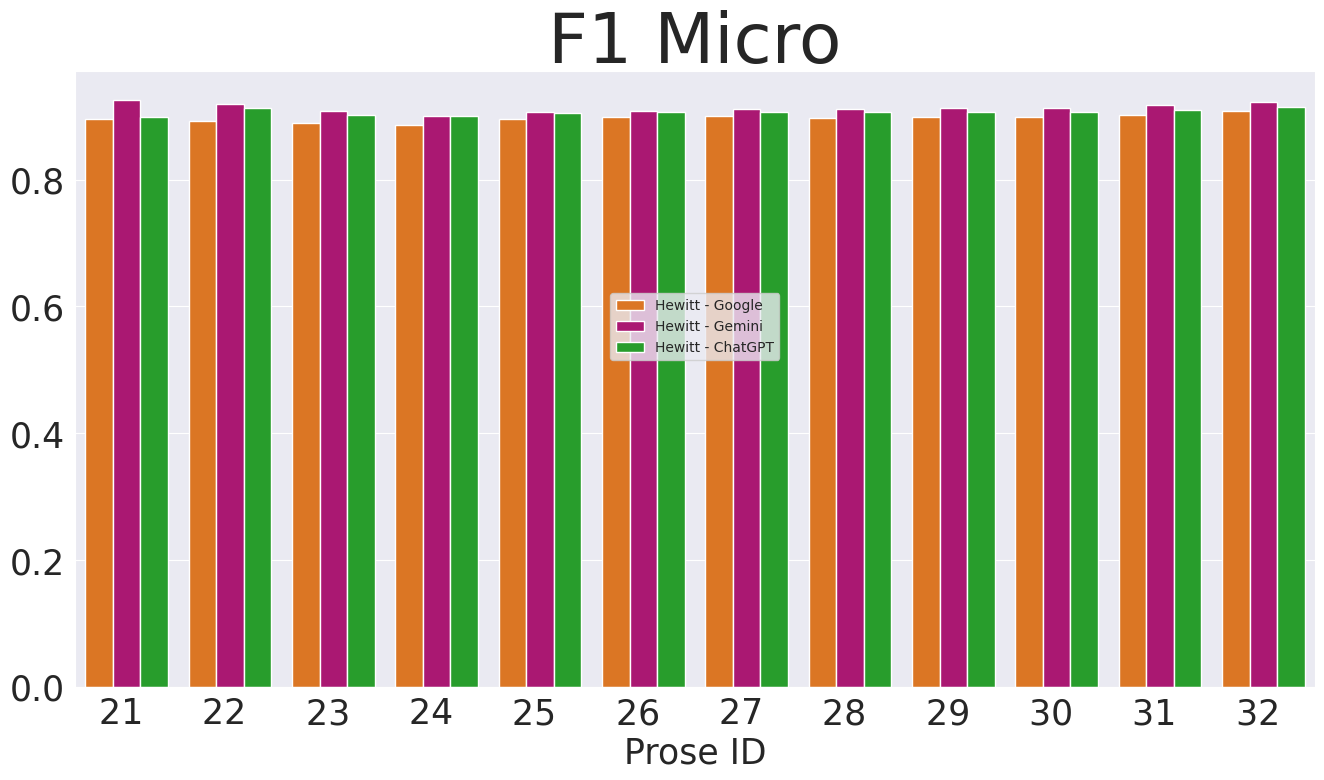

In [48]:
colors = ["orange", "magenta", "green"]  
myPalette = sns.xkcd_palette(colors)
fig_dims = (16, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set_style("darkgrid")
score_plot = sns.barplot(
    x='Prose', 
    y='value', 
    hue='variable', 
    data=data, 
    palette=myPalette, 
    legend=True,
    ax=ax
)
sns.move_legend(score_plot, 'upper center', title='', bbox_to_anchor=(0.5, 0.65))
plt.ylabel('')
plt.xlabel('Prose ID')
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
ax.xaxis.label.set_size(25)
plt.title('F1 Micro', fontsize=50)
plt.savefig('results/prose/graphs/f1_micro_all.png')

In [49]:
sentiment_polarity = {
    # 'Surprise': 0,
    # 'Joking': 0,
    'Pessimistic': -3,
    'Anxious': -2,
    'Sad':  -2,
    'Annoyed': -1,
    'Denial': -4,
    'Optimistic': 3,
    'Thankful': 2,
    'Empathetic': 0
}

In [50]:
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
init_notebook_mode(connected=False)
warnings.filterwarnings("ignore")

In [51]:
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']

In [52]:
df_sentiments = pd.DataFrame(columns=['Prose', 'Polarity', 'Author'])
for source in sources:
    for prose in prose_names:
        polarity = 0
        df_prose = pd.read_csv('results/prose/sentiment/' + source + prose)
        for i, row in df_prose.iterrows():
            if row['Optimistic'] == 1:
                polarity += 3
            if row['Thankful'] == 1:
                polarity += 2
            if row['Empathetic'] == 1:
                polarity += 0
            if row['Denial'] == 1:
                polarity -= 4 
            if row['Annoyed'] == 1:
                polarity -= 1
            if row['Sad'] == 1:
                polarity -= 2
            if row['Anxious'] == 1:
                polarity -= 2
            if row['Pessimistic'] == 1:
                polarity -= 3

        df_temp = pd.DataFrame([[prose[:2], polarity, source]], columns = ['Prose', 'Polarity', 'Author'])
        df_sentiments = pd.concat([df_sentiments, df_temp], axis=0, ignore_index=True)

df_sentiments['Author'] = df_sentiments['Author'].\
    str.replace('en/', 'Hewitt').\
    str.replace('ggl/', 'Google').\
    str.replace('gem/', 'Gemini').\
    str.replace('gpt/', 'ChatGPT')

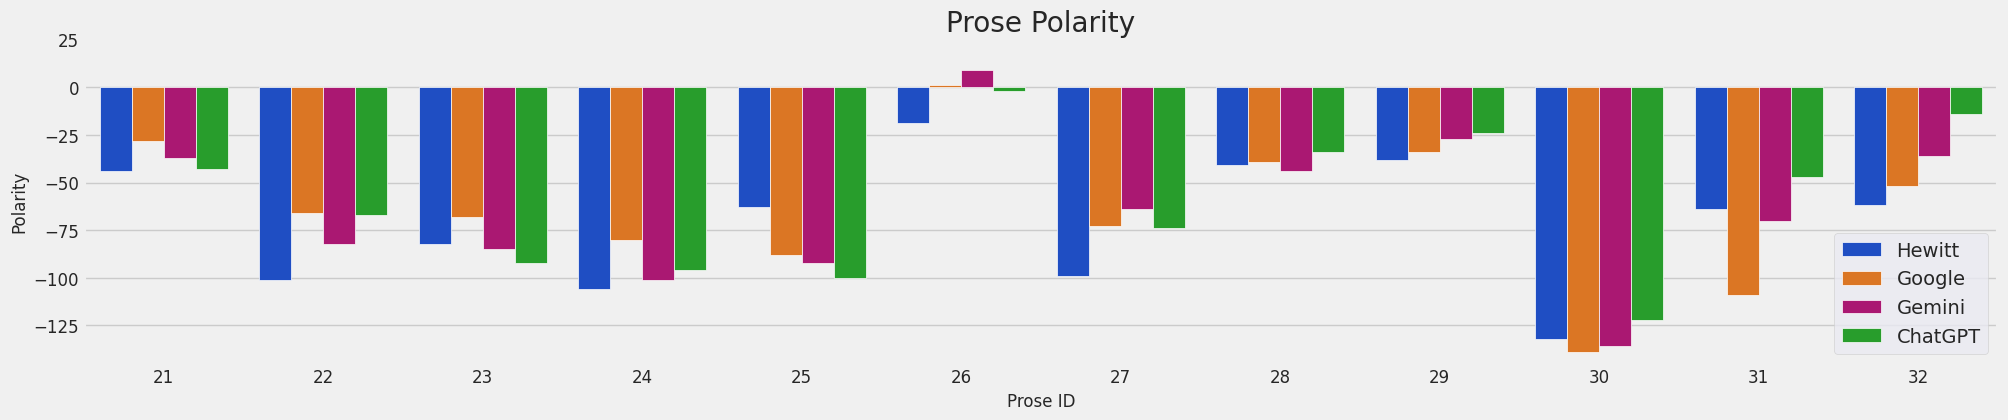

In [53]:
colors = ["blue", "orange", "magenta", "green"]  
myPalette = sns.xkcd_palette(colors)
fig_dims = (22, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set_style("darkgrid")
polarity_plot = sns.barplot(
    x='Prose', 
    y='Polarity', 
    hue='Author', 
    data=df_sentiments, 
    palette=myPalette, 
    legend=True,
    ax=ax
)
sns.move_legend(polarity_plot, 'lower right', title='')
plt.title("Prose Polarity")
plt.ylabel('Polarity')
plt.xlabel('Prose ID')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylim((-145,25))
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
plt.savefig('results/prose/graphs/polarity_all.png')

In [54]:
print(round(df_sentiments[df_sentiments['Author'] == 'Hewitt']['Polarity'].sum() / 12, 2))
print(round(df_sentiments[df_sentiments['Author'] == 'Google']['Polarity'].sum() / 12, 2))
print(round(df_sentiments[df_sentiments['Author'] == 'Gemini']['Polarity'].sum() / 12, 2))
print(round(df_sentiments[df_sentiments['Author'] == 'ChatGPT']['Polarity'].sum() / 12, 2))

-70.92
-64.58
-63.75
-59.58


In [55]:
def flatten(lst):
    new_list = []
    for sublist in lst:
      if isinstance(sublist, list):
        for item in sublist:
          new_list.append(item)
      else:
        new_list.append(sublist)
    return new_list

In [86]:
topic_df = pd.read_csv('results/prose/sentiment/' + 'gpt/' + prose_names[0])
topic_df = topic_df.drop(['Unnamed: 0', 'Official report', 'Joking'], axis=1)

for poem in prose_names[1:]:
    df = pd.read_csv('results/prose/sentiment/' + 'gpt/' + poem)
    df = df.drop(['Unnamed: 0', 'Official report', 'Joking'], axis=1)
    topic_df = pd.concat([topic_df, df], axis=0)

In [87]:
stop_words = stopwords.words('english')
newStopWords = []
stop_words.extend(newStopWords)

def remove_stopwords(tweets):
    return [[word for word in gensim.utils.simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]

def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))

def preprocessing(df):
    df['Tweet'] = df['Tweet'].str.lower()                                                      # Convert to lowercase
    df['Tweet'] = df['Tweet'].str.replace(r'[^a-zA-Z#]', ' ', regex=True)                      # Remove punctuations
    df['Tweet'] = df['Tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))     # Remove short words
    df['Tweet tokens'] = list(tokenize(df['Tweet']))
    df['tokens_no_stop'] = remove_stopwords(df['Tweet'])
    df['tokens_no_stop_joined'] = df['Tweet'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in stop_words]))
    return df

def retrieve_text(df):
    doc = '. '.join(df['tokens_no_stop_joined'])
    return doc

def ngrams_series_func(data, n):
    wordList = re.sub("[^\w]", " ",  data).split()
    ngrams_series = (pd.Series(nltk.ngrams(wordList, n)).value_counts())[:5]
    return ngrams_series

In [88]:
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth": 1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center=90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center=0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center=9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df, this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df, this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

In [89]:
topic_df = preprocessing(topic_df)
topic_df.head()

Tweet  \
0                                                                                                                                                                               have come dense forest   
1                                                                                long alive will grace forest grass that rough cliff watching from afar with beauty will spread fragrance surroundings   
2  everyone loves look that rotting stump eyes always fixed smiles sometimes wanting come closer kiss cannot only smiles from distance poor thing though unattractive great kindness spreads over face   
3                                                                                                                                                                        only that which rejoices life   
4                                                                                 even dead trees support from above themselves bare headed they cover with their branches violet cold harmed anything   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         0.0       0.0         0.0          1.0      0.0  1.0      0.0   
1         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
2         0.0       0.0         0.0          0.0      0.0  1.0      0.0   
3         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
4         0.0       0.0         1.0          0.0      1.0  0.0      0.0   

   Denial  \
0     0.0   
1     0.0   
2     0.0   
3     0.0   
4     0.0   

                                                                                                                                                                                                                        Tweet tokens  \
0                                                                                                                                                                                                        [have, come, dense, forest]   
1                                                                                           [long, alive, will, grace, forest, grass, that, rough, cliff, watching, from, afar, with, beauty, will, spread, fragrance, surroundings]   
2  [everyone, loves, look, that, rotting, stump, eyes, always, fixed, smiles, sometimes, wanting, come, closer, kiss, cannot, only, smiles, from, distance, poor, thing, though, unattractive, great, kindness, spreads, over, face]   
3                                                                                                                                                                                                [only, that, which, rejoices, life]   
4                                                                                            [even, dead, trees, support, from, above, themselves, bare, headed, they, cover, with, their, branches, violet, cold, harmed, anything]   

                                                                                                                                                                                              tokens_no_stop  \
0                                                                                                                                                                                      [come, dense, forest]   
1                                                                                                 [long, alive, grace, forest, grass, rough, cliff, watching, afar, beauty, spread, fragrance, surroundings]   
2  [everyone, loves, look, rotting, stump, eyes, always, fixed, smiles, sometimes, wanting, come, closer, kiss, cannot, smiles, distance, poor, thing, though, unattractive, great, kindness, spreads, face]   
3                                                                                                                                                                                           [rejoices, life]   
4                

In [90]:
text = retrieve_text(topic_df)
text.split('. ')

['come dense forest',
 'long alive grace forest grass rough cliff watching afar beauty spread fragrance surroundings',
 'everyone loves look rotting stump eyes always fixed smiles sometimes wanting come closer kiss cannot smiles distance poor thing though unattractive great kindness spreads face',
 'rejoices life',
 'even dead trees support bare headed cover branches violet cold harmed anything',
 'heavy rain reach directly rain strip leaves',
 'without leaves death',
 'trees birch beech hazel poplar surround guard keep rain moisture branches leaves slowly drip onto washing face',
 'lift head wish could sing creator given gift praise high clouds protective trees mountains meadows chirping birds green feathers dance yellow leaves sometimes chirp play rejoicing life',
 'month life better someone else twenty four months life long long life',
 'morning beech bird sang near beautiful throated chirping like admired looking chest shoulders everyone admires everyone rejoices life everyone love

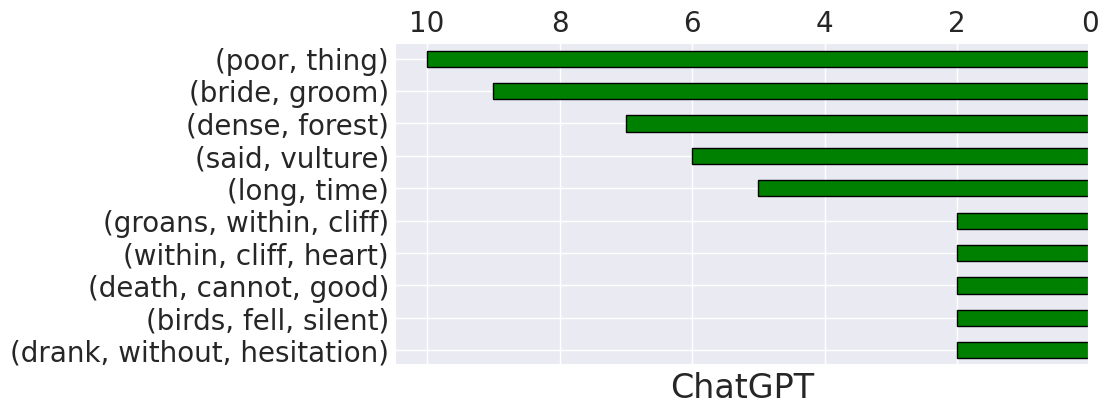

In [91]:
bigram1 = ngrams_series_func(text, 2)
trigram1 = ngrams_series_func(text, 3)
ngram1 = pd.concat([bigram1, trigram1])

plt.rcParams.update({'font.size': 20})
fig, ax=plt.subplots(1,1, figsize=(8,4))
barh_ax = ax

ngram1[::-1].plot.barh(ax=barh_ax, color='green', **barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('ChatGPT')
barh_ax.set_ylabel('', fontsize=50)
plt.savefig('results/prose/graphs/ngrams/chatgpt.png')

In [116]:
topic_df = pd.read_csv('results/prose/sentiment/' + 'gpt/' + prose_names[0])
topic_df = topic_df.drop(['Unnamed: 0', 'Official report', 'Joking'], axis=1)
for i, row in topic_df.iterrows():
    polarity = 0.0
    if row['Optimistic'] == 1:
        polarity += 3
    if row['Thankful'] == 1:
        polarity += 2
    if row['Empathetic'] == 1:
        polarity += 0
    if row['Denial'] == 1:
        polarity -= 4 
    if row['Annoyed'] == 1:
        polarity -= 1
    if row['Sad'] == 1:
        polarity -= 2
    if row['Anxious'] == 1:
        polarity -= 2
    if row['Pessimistic'] == 1:
        polarity -= 3
    topic_df.at[i, 'Polarity'] = polarity

for prose in prose_names[1:]:
    df = pd.read_csv('results/prose/sentiment/' + 'gpt/' + prose)
    df = df.drop(['Unnamed: 0', 'Official report', 'Joking'], axis=1)
    for i, row in df.iterrows():
        polarity = 0.0
        if row['Optimistic'] == 1:
            polarity += 3
        if row['Thankful'] == 1:
            polarity += 2
        if row['Empathetic'] == 1:
            polarity += 0
        if row['Denial'] == 1:
            polarity -= 4 
        if row['Annoyed'] == 1:
            polarity -= 1
        if row['Sad'] == 1:
            polarity -= 2
        if row['Anxious'] == 1:
            polarity -= 2
        if row['Pessimistic'] == 1:
            polarity -= 3
        df.at[i, 'Polarity'] = polarity
    topic_df = pd.concat([topic_df, df], axis=0, ignore_index=True)

In [117]:
stop_words = stopwords.words('english')

def remove_stopwords(tweets):
    return [[word for word in gensim.utils.simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]

def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))

def preprocessing(df):
    df['Tweet'] = df['Tweet'].str.lower()                                                      # Convert to lowercase
    df['Tweet'] = df['Tweet'].str.replace(r'[^a-zA-Z#]', ' ', regex=True)                      # Remove punctuations
    df['Tweet'] = df['Tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))     # Remove short words
    df['Tweet tokens'] = list(tokenize(df['Tweet']))
    df['tokens_no_stop'] = remove_stopwords(df['Tweet'])
    df['tokens_no_stop_joined'] = df['Tweet'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in stop_words]))
    return df

def retrieve_text(df):
    doc = '. '.join(df['tokens_no_stop_joined'])
    return doc

def ngrams_series_func(data, n):
    wordList = re.sub("[^\w]", " ",  data).split()
    ngrams_series = (pd.Series(nltk.ngrams(wordList, n)).value_counts())[:5]
    return ngrams_series

In [118]:
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df, this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df, this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax=this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top', 'bottom', 'left', 'right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)


In [119]:
topic_df

Tweet  \
0                                                                                                                                                                                                                           I have come to the dense forest...   
1                                                                                           As long as I am alive, I will grace the forest, the grass, and that rough cliff watching from afar with my beauty. I will spread my fragrance to the surroundings.   
2    Everyone loves me: look at that rotting stump, its eyes always fixed on me, it smiles sometimes, wanting to come closer, to kiss me, but it cannot; it only smiles at me from a distance, poor thing, though unattractive, a great kindness spreads ov...   
3                                                                                                                                                                                                                   Is it only that which rejoices in my life?   
4                                                                                               Even the dead trees support me from above, themselves bare-headed, they cover me with their branches: "Let our violet not get cold, or be harmed by anything."   
..                                                                                                                                                                                                                                                         ...   
916                                                                                                                                                                                     The birds scattered, some perched on trees, others circled high above.   
917                                                                                                                             Only the eagle and the woodpecker remained below; the sick mouse also found a burrow to hide in at the sound of the commotion.   
918                                                                                                       The eagle freed the woodpecker and said: “I forgive you this transgression because you were drunk, but don’t dare do it again, or woe to your hide.”   
919                                                                                                                                                                                        Then he flew up, as if to pierce the sky, and began circling above.   
920                                                                         Ketevan and Zakara retreated into the dense forest: they spent the day in each other’s arms, kissing and embracing, and fell asleep side by side on a beech branch in the evening.   

     Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0           0.0       0.0         0.0          1.0      0.0  1.0      0.0   
1           1.0       0.0         0.0          0.0      0.0  0.0      0.0   
2           0.0       0.0         0.0          0.0      0.0  1.0      0.0   
3           1.0       0.0         1.0          0.0      0.0  0.0      0.0   
4           0.0       0.0         1.0          0.0      1.0  0.0      0.0   
..          ...       ...         ...          ...      ...  ...      ...   
916         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
917         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
918         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
919         0.0       0.0         0.0          0.0      0.0  0.0      0.0   
920         0.0       0.0         0.0          0.0      0.0  1.0      0.0   

     Denial  Polarity  
0       0.0      -5.0  
1       0.0       3.0  
2       0.0      -2.0  
3       0.0       3.0  
4       0.0      -2.0  
..      ...       ...  
916     0.0       0.0  
917     0.0       0.0  
918     0.0

In [120]:
topic_df = preprocessing(topic_df)
topic_df.head()

Tweet  \
0                                                                                                                                                                               have come dense forest   
1                                                                                long alive will grace forest grass that rough cliff watching from afar with beauty will spread fragrance surroundings   
2  everyone loves look that rotting stump eyes always fixed smiles sometimes wanting come closer kiss cannot only smiles from distance poor thing though unattractive great kindness spreads over face   
3                                                                                                                                                                        only that which rejoices life   
4                                                                                 even dead trees support from above themselves bare headed they cover with their branches violet cold harmed anything   

   Optimistic  Thankful  Empathetic  Pessimistic  Anxious  Sad  Annoyed  \
0         0.0       0.0         0.0          1.0      0.0  1.0      0.0   
1         1.0       0.0         0.0          0.0      0.0  0.0      0.0   
2         0.0       0.0         0.0          0.0      0.0  1.0      0.0   
3         1.0       0.0         1.0          0.0      0.0  0.0      0.0   
4         0.0       0.0         1.0          0.0      1.0  0.0      0.0   

   Denial  Polarity  \
0     0.0      -5.0   
1     0.0       3.0   
2     0.0      -2.0   
3     0.0       3.0   
4     0.0      -2.0   

                                                                                                                                                                                                                        Tweet tokens  \
0                                                                                                                                                                                                        [have, come, dense, forest]   
1                                                                                           [long, alive, will, grace, forest, grass, that, rough, cliff, watching, from, afar, with, beauty, will, spread, fragrance, surroundings]   
2  [everyone, loves, look, that, rotting, stump, eyes, always, fixed, smiles, sometimes, wanting, come, closer, kiss, cannot, only, smiles, from, distance, poor, thing, though, unattractive, great, kindness, spreads, over, face]   
3                                                                                                                                                                                                [only, that, which, rejoices, life]   
4                                                                                            [even, dead, trees, support, from, above, themselves, bare, headed, they, cover, with, their, branches, violet, cold, harmed, anything]   

                                                                                                                                                                                              tokens_no_stop  \
0                                                                                                                                                                                      [come, dense, forest]   
1                                                                                                 [long, alive, grace, forest, grass, rough, cliff, watching, afar, beauty, spread, fragrance, surroundings]   
2  [everyone, loves, look, rotting, stump, eyes, always, fixed, smiles, sometimes, wanting, come, closer, kiss, cannot, smiles, distance, poor, thing, though, unattractive, great, kindness, spreads, face]   
3                                                                                                                                                                    

In [121]:
df_positive = topic_df[topic_df['Polarity'] > 0.0]
df_negative = topic_df[topic_df['Polarity'] < 0.0]
# df_optimistic = topic_df[topic_df['Optimistic'] == 1]
# df_pessimistic = topic_df[topic_df['Pessimistic'] == 1]
# df_denial = topic_df[topic_df['Denial'] == 1]
# df_annoyed = topic_df[topic_df['Annoyed'] == 1]
# df_thankful = topic_df[topic_df['Thankful'] == 1]
# df_empathetic = topic_df[topic_df['Empathetic'] == 1]
# df_anxious = topic_df[topic_df['Anxious'] == 1]
# df_sad =  topic_df[topic_df['Sad'] == 1]
# df_joking = topic_df[topic_df['Joking'] == 1]

In [122]:
text_positive = '. '.join(df_positive.tokens_no_stop_joined)
text_negative = '. '.join(df_negative.tokens_no_stop_joined)
# text_optimistic = '. '.join(df_optimistic.tokens_no_stop_joined)
# text_pessimistic = '. '.join(df_pessimistic.tokens_no_stop_joined)
# text_denial = '. '.join(df_denial.tokens_no_stop_joined)
# text_annoyed = '. '.join(df_annoyed.tokens_no_stop_joined)
# text_thankful = '. '.join(df_thankful.tokens_no_stop_joined)
# text_empathetic = '. '.join(df_empathetic.tokens_no_stop_joined)
# text_anxious = '. '.join(df_anxious.tokens_no_stop_joined)
# text_sad = '. '.join(df_sad.tokens_no_stop_joined)
# text_joking = '. '.join(df_joking.tokens_no_stop_joined)

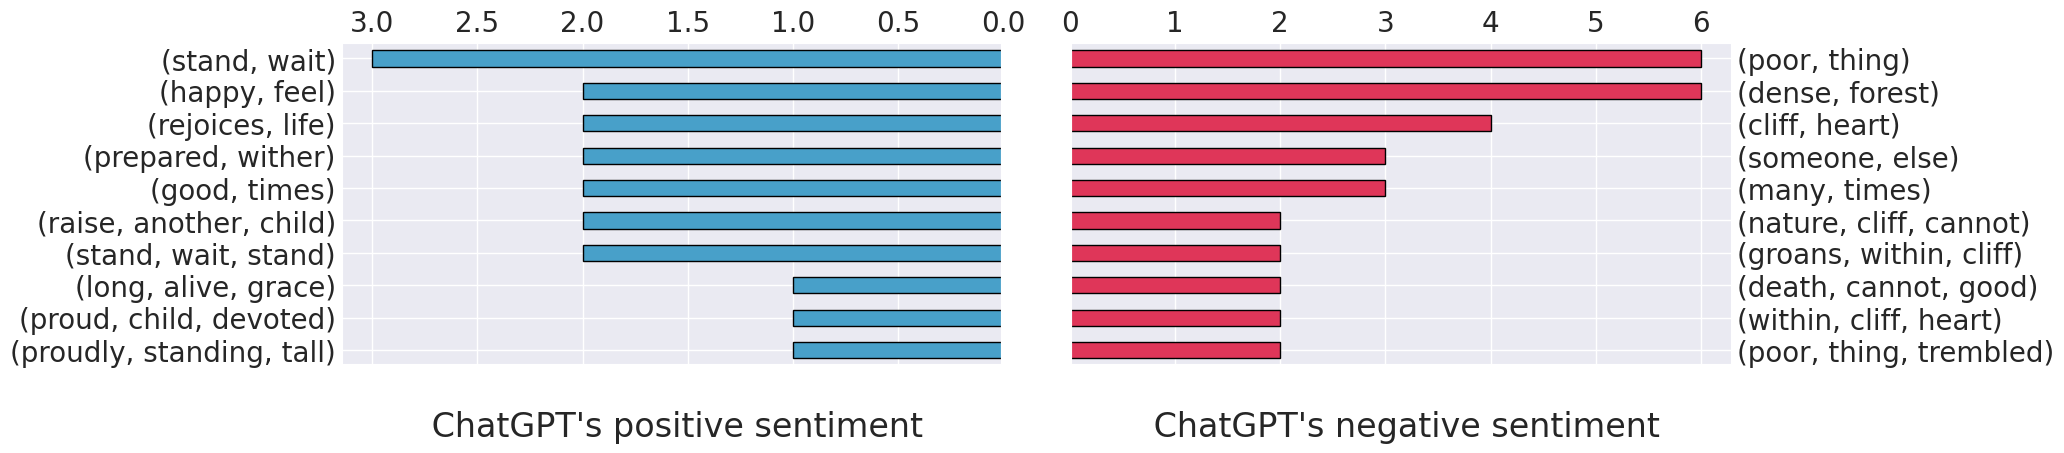

In [123]:
bigram1 = ngrams_series_func(text_positive, 2)
trigram1 = ngrams_series_func(text_positive, 3)
bigram2 = ngrams_series_func(text_negative, 2)
trigram2 = ngrams_series_func(text_negative, 3)

ngram1 = pd.concat([bigram1, trigram1])
ngram2 = pd.concat([bigram2, trigram2])

plt.rcParams.update({'font.size': 20})
fig, ax=plt.subplots(1, 2, figsize=(16, 4), gridspec_kw = {'width_ratios':[1,1], 'wspace': 0.1, 'hspace': 0.1})

barh_ax = ax[0]
ngram1[::-1].plot.barh(ax=barh_ax, color=barcolors[3], **barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel("\n ChatGPT's positive sentiment")
barh_ax.set_ylabel('',fontsize=50)

barh_ax = ax[1]
ngram2[::-1].plot.barh(ax=barh_ax, color=barcolors[6],**barstyle)
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.set_xlim(barh_ax.get_xlim())
barh_ax.yaxis.tick_right()
barh_ax.set_ylabel('', fontsize=50)
barh_ax.set_xlabel("\n ChatGPT's negative sentiment")
plt.savefig('results/prose/graphs/ngrams/chatgpt_pos_neg.png')

In [124]:
sentiments = ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Joking']

def return_sentiments(data, row):
    text = ''
    for sentiment in sentiments:
        if data[sentiment][row] == 1:
            text += sentiment
            text += ', '
    return text

In [125]:
sentiments = ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Joking']
data = pd.DataFrame(columns=[
    'Prose', 'Verse No.', 'Author', 'Verse', 'Predicted Sentiments', 
    'Hewitt - Google', 'Hewitt - Gemini', 'Hewitt - ChatGPT'
])
count = 0

for prose in prose_names:
    semantic_comparsion = pd.read_csv('results/prose/similarity/cosine_similarity.csv')
    
    df_ggl = pd.read_csv('results/prose/sentiment/' + 'ggl/' + prose)
    df_ggl = df_ggl.drop(['Unnamed: 0', 'Official report'], axis=1)
    df_gem = pd.read_csv('results/prose/sentiment/' + 'gem/' + prose)
    df_gem = df_gem.drop(['Unnamed: 0', 'Official report'], axis=1)
    df_gpt = pd.read_csv('results/prose/sentiment/' + 'gpt/' + prose)
    df_gpt = df_gpt.drop(['Unnamed: 0', 'Official report'], axis=1)

    for ii in range(3 * df_ggl.shape[0]):
        
        if ii % 3 == 0:
            pr_sentiments = return_sentiments(df_ggl, ii // 3)
            dict2 = {
                'Prose': [prose], 
                'Verse No.': [ii // 3 + 1], 
                'Author':['Google'],
                'Verse': [df_ggl['Tweet'][ii // 3]], 
                'Predicted Sentiments': [pr_sentiments],
                'Hewitt - Google': [semantic_comparsion['Hewitt - Google'][ii // 3]], 
                'Hewitt - Gemini': [semantic_comparsion['Hewitt - Gemini'][ii // 3]],
                'Hewitt - ChatGPT': [semantic_comparsion['Hewitt - ChatGPT'][ii // 3]]
            }
            df_temp = pd.DataFrame(dict2)
            data = pd.concat([data, df_temp], ignore_index=True)

        elif ii % 3 == 1:
            pr_sentiments = return_sentiments(df_gem, ii // 3)
            dict2 = {
                'Prose': [' '], 
                'Verse No.': [ii // 3 + 1], 
                'Author':['Gemini'], 
                'Verse': [df_gem['Tweet'][ii // 3]], 
                'Predicted Sentiments': [pr_sentiments],
                'Hewitt - Google': [' '], 
                'Hewitt - Gemini': [' '],
                'Hewitt - ChatGPT': [' ']
            }
            df_temp = pd.DataFrame(dict2)
            data = pd.concat([data, df_temp], ignore_index=True)

        else:
            pr_sentiments = return_sentiments(df_gpt, ii // 3)
            dict2 = {
                'Prose': [' '], 
                'Verse No.': [ii // 3 + 1], 
                'Author':['ChatGPT'], 
                'Verse': [df_gpt['Tweet'][ii // 3]], 
                'Predicted Sentiments': [pr_sentiments],
                'Hewitt - Google': [' '], 
                'Hewitt - Gemini': [' '],
                'Hewitt - ChatGPT': [' ']
            }
            df_temp = pd.DataFrame(dict2)
            data=pd.concat([data, df_temp], ignore_index=True)

data

Prose Verse No.   Author  \
0                      21_violet.md         1   Google   
1                                           1   Gemini   
2                                           1  ChatGPT   
3                      21_violet.md         2   Google   
4                                           2   Gemini   
...                             ...       ...      ...   
2758                                      158   Gemini   
2759                                      158  ChatGPT   
2760  32_the_wedding_of_the_jays.md       159   Google   
2761                                      159   Gemini   
2762                                      159  ChatGPT   

                                                                                                                                                                                           Verse  \
0                                                                                                                                                             I have come to the dense forest...   
1                                                                                                                                                               I have come to a dense forest...   
2                                                                                                                                                             I have come to the dense forest...   
3                                                    As long as I am alive, I will sweeten the forest, the grass, and the mossy rock with my beauty, I will sprinkle spices on the surroundings.   
4                                As long as I am alive, I will delight the forest, the grass, and that heart-shaped rock looking at me from afar with my beauty, I will spread fragrance around.   
...                                                                                                                                                                                          ...   
2758                                                                                               The eagle itself took flight, soaring high as if touching the sky, and began to circle above.   
2759                                                                                                                         Then he flew up, as if to pierce the sky, and began circling above.   
2760  Ketevan and Zakara also took shelter in the dense forest: they spent that day hugging and kissing each other, and in the evening they slept side by side on the beech branch of the other.   
2761              Ketevan and Zakara also sought refuge in the dense forest, spending the day and evening in each other's embrace. They fell asleep side by side on a branch of a hornbeam tree.   
2762          Ketevan and Zakara retreated into the dense forest: they spent the day in each other’s arms, kissing and embracing, and fell asleep side by side on a beech branch in the evening.   

      Predicted Sentiments Hewitt - Google Hewitt - Gemini Hewitt - ChatGPT  
0       Pessimistic, Sad,         0.802988        0.827873         0.802988  
1       Pessimistic, Sad,                                                    
2       Pessimistic, Sad,                                                    
3     Optimistic, Joking,         0.831107        0.876884         0.846976  
4     Optimistic, Joking,                                                    
...                    ...             ...             ...              ...  
2758              Joking,                                                    
2759              Joking,                                                    
2760              Joking,         0.669401        0.669401         0.695002  
2761     Empathetic, Sad,                                                    
2762         Sad, Joking,                                                    

[2763 rows x 8 columns]